[Normalized data](#1)

[Missings stat](#2)

[Feature Splitting](#3)

[Imputation](#4)

1. [What's the number of jobs posting per category (Top 10)](#6)

2. [What's the salary distribution per job category? ](#7)

3. [Is there any correlation between the higher degree and the salary?](#8)
    
    1. [Answer](#9)


4. [What's the job posting having the highest salary per agency? ](#10)

5. [What's the job postings average salary per agency for the last 2 years?](#11)

6. [What are the highest paid skills in the US market?](#12)


In [1]:
import sys; 
sys.path.insert(0, '..')
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
import utils.processing_fuctions 
from utils.processing_fuctions import normalize_column_names, column_types
from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, lit, udf, concat, lower, desc, asc, round, row_number, isnan, when, count, col, cast, substring, expr
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
import findspark
import seaborn as sns
import pandas as pd

In [2]:
findspark.init()

In [3]:
from pyspark.sql import SparkSession
import os
spark = SparkSession.builder.appName("pyspark").getOrCreate()

22/09/23 18:36:11 WARN Utils: Your hostname, Vladislavs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.28.171.123 instead (on interface en0)
22/09/23 18:36:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/23 18:36:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/23 18:36:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/09/23 18:36:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/09/23 18:36:12 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/09/23 18:36:12 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


### Read data

In [4]:
df = spark.read.option('escape','"').options(inferSchema='True').csv("../../dataset/nyc-jobs.csv", header=True)

# Normalized data <a id="1"></a> <br>

In [5]:
df = normalize_column_names(df).dropDuplicates()

In [6]:
df.count()

22/09/23 18:36:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


2915

In [7]:
df.head()

Row(job_id=87990, agency='DEPARTMENT OF BUSINESS SERV.', posting_type='Internal', #_of_positions=1, business_title='Account Manager', civil_service_title='CONTRACT REVIEWER (OFFICE OF L', title_code_no='40563', level='1', job_category=None, full-time/part-time_indicator=None, salary_range_from=42405.0, salary_range_to=65485.0, salary_frequency='Annual', work_location='110 William St. N Y', division/work_unit='Strategy & Analytics', job_description='Division of Economic & Financial Opportunity (DEFO)    Mayor Michael R. Bloomberg and SBS are committed to encouraging a competitive and diverse New York City business environment by promoting the growth and success of minority and women-owned companies.  New York Cityâ€™s Minority and Women-owned Business Enterprise (M/WBE) program is designed to help these historically underserved groups become more competitive.    JOB DESCRIPTION           The Account Manager will provide a range of supportive services to City agency purchasing personnel 

In [8]:
column_types(df)

Numeric columns ['job_id', '#_of_positions', 'salary_range_from', 'salary_range_to']

Categorical columns ['agency', 'posting_type', 'business_title', 'civil_service_title', 'title_code_no', 'level', 'job_category', 'full-time/part-time_indicator', 'salary_frequency', 'work_location', 'division/work_unit', 'job_description', 'minimum_qual_requirements', 'preferred_skills', 'additional_information', 'to_apply', 'hours/shift', 'work_location_1', 'recruitment_contact', 'residency_requirement']

Timestamp columns ['posting_date', 'post_until', 'posting_updated', 'process_date']


In [9]:
df

DataFrame[job_id: int, agency: string, posting_type: string, #_of_positions: int, business_title: string, civil_service_title: string, title_code_no: string, level: string, job_category: string, full-time/part-time_indicator: string, salary_range_from: double, salary_range_to: double, salary_frequency: string, work_location: string, division/work_unit: string, job_description: string, minimum_qual_requirements: string, preferred_skills: string, additional_information: string, to_apply: string, hours/shift: string, work_location_1: string, recruitment_contact: string, residency_requirement: string, posting_date: timestamp, post_until: timestamp, posting_updated: timestamp, process_date: timestamp]

In [10]:
pdf = df.toPandas()

In [11]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   job_id                         2915 non-null   int32         
 1   agency                         2915 non-null   object        
 2   posting_type                   2915 non-null   object        
 3   #_of_positions                 2915 non-null   int32         
 4   business_title                 2915 non-null   object        
 5   civil_service_title            2915 non-null   object        
 6   title_code_no                  2915 non-null   object        
 7   level                          2915 non-null   object        
 8   job_category                   2913 non-null   object        
 9   full-time/part-time_indicator  2722 non-null   object        
 10  salary_range_from              2915 non-null   float64       
 11  salary_range_to  

In [12]:
pd.set_option('display.max_rows', 500)

In [13]:
pdf.isnull().mean() * 100

job_id                             0.000000
agency                             0.000000
posting_type                       0.000000
#_of_positions                     0.000000
business_title                     0.000000
civil_service_title                0.000000
title_code_no                      0.000000
level                              0.000000
job_category                       0.068611
full-time/part-time_indicator      6.620926
salary_range_from                  0.000000
salary_range_to                    0.000000
salary_frequency                   0.000000
work_location                      0.000000
division/work_unit                 0.000000
job_description                    0.000000
minimum_qual_requirements          0.686106
preferred_skills                  13.276158
additional_information            37.289880
to_apply                           0.034305
hours/shift                       69.948542
work_location_1                   54.133791
recruitment_contact             

# Missings stat  <a id="2"></a> <br>

<Figure size 1080x1080 with 0 Axes>

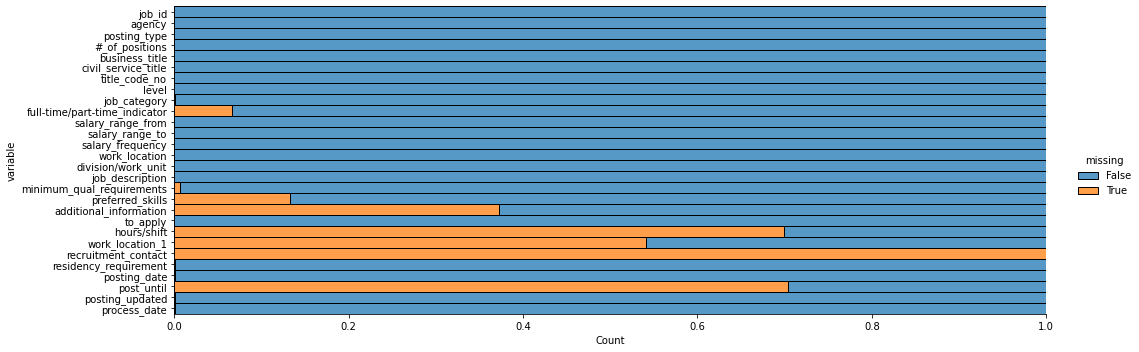

In [14]:
plt.figure(figsize=(15,15))
sns.displot(
    data=pdf.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=3
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=300)

We can see that the "Recruitment Contact" column is completely empty
And we can probably drop it.

Lets see on "Full-Time/Part-Time indicator","Job Category","Preferred Skills","Additional Information","Minimum Qual Requirements","To Apply", "Hours/Shift", "Work Location 1", "Residency Requirement"

All of them are "Categorical columns"

"Posting Date" "Post Until" "Posting Updated" "Process Date" are datetime, and we can see that "Post Until" is missing on 70% its mean that Job vacancies is active


# Feature Splitting <a id="3"></a> <br>

In [15]:
df = df.withColumn('posting_date', df['posting_date'].cast('string').substr(1, 10))\
.withColumn('post_until', df['post_until'].cast('string').substr(1, 10))\
.withColumn('posting_updated', df['posting_updated'].cast('string').substr(1, 10))\
.withColumn('process_date', df['process_date'].cast('string').substr(1, 10))

#Remove excess and convert the date to string format convenient for further aggregation, at any time you can convert it to date format

# Imputation<a id="4"></a> <br>

In [16]:
df = df.na.fill("5999-12-31",["post_until"]) #This method is often used in banks to fill in blank data

In [17]:
df = df.na.fill("NAN",["preferred_skills"])

#### So now we convert columns in date type, which is better for future aggregations

# What's the number of jobs posting per category (Top 10) <a id="6"></a> <br>

In [18]:
df.groupBy("job_category").count().sort(desc("count")).head(10)

[Row(job_category='Engineering, Architecture, & Planning', count=497),
 Row(job_category='Technology, Data & Innovation', count=312),
 Row(job_category='Legal Affairs', count=224),
 Row(job_category='Public Safety, Inspections, & Enforcement', count=179),
 Row(job_category='Building Operations & Maintenance', count=177),
 Row(job_category='Finance, Accounting, & Procurement', count=168),
 Row(job_category='Administration & Human Resources', count=131),
 Row(job_category='Constituent Services & Community Programs', count=129),
 Row(job_category='Health', count=125),
 Row(job_category='Policy, Research & Analysis', count=124)]

In [19]:
df.groupBy("job_category").count().sort(desc("count")).show(10)

+--------------------+-----+
|        job_category|count|
+--------------------+-----+
|Engineering, Arch...|  497|
|Technology, Data ...|  312|
|       Legal Affairs|  224|
|Public Safety, In...|  179|
|Building Operatio...|  177|
|Finance, Accounti...|  168|
|Administration & ...|  131|
|Constituent Servi...|  129|
|              Health|  125|
|Policy, Research ...|  124|
+--------------------+-----+
only showing top 10 rows



In [20]:
df.groupBy("job_category").count().sort(desc("count")).limit(10).toPandas().to_csv('result/1_jobs_posting_per_category_Top_10.csv')

In [21]:
df.groupBy("job_category").count().sort(desc("count")).toPandas().to_csv('result/1_jobs_posting_per_category_all.csv')

#  What's the salary distribution per job category?<a id="7"></a> <br>

In [22]:
def normalized_salary_from(frequency,salary_from,Hours):
    if frequency == "Hourly":
        return salary_from * Hours * 52
    elif frequency == "Daily":
        return salary_from * 5 * 52
    else:
        return salary_from

def normalized_salary_to(frequency,salary_from,Hours):
    if frequency == "Hourly":
        return salary_from * Hours * 52
    elif frequency == "Daily":
        return salary_from*5*52
    else:
        return salary_from

In [23]:
udf_normalized_salary_from = udf(normalized_salary_from, DoubleType())
udf_normalized_salary_to = udf(normalized_salary_to, DoubleType())

In [24]:
df = df.withColumn("Hours", 
                    when((col("hours/shift").contains("35")),35)\
                   .when((col("hours/shift").contains("40")),40)\
                   .when((col("hours/shift").contains("32")),32)\
                   .otherwise(40))

In [25]:
df = df.withColumn("normalized_salary_from",round(udf_normalized_salary_from(col("salary_frequency"),col("salary_range_from"),col("Hours")),2))

In [26]:
df = df.withColumn("normalized_salary_to",round(udf_normalized_salary_to(col("salary_frequency"),col("salary_range_to"),col("Hours")),2))

In [27]:
df.filter("normalized_salary_from = 0.0").count()

16

In [28]:
avg_full_norm_sal_from={}
for i in df.select(mean(col("normalized_salary_from"))).collect():
    avg_full_norm_sal_from.update(i.asDict())

In [29]:
def normalized_salary_from_with_avg(salary_range_from):
    if salary_range_from == 0.0:
        return avg_full_norm_sal_from["avg(normalized_salary_from)"]
    else:
        return salary_range_from

normalized_salary_from_with_avg = udf(normalized_salary_from_with_avg, DoubleType())

In [30]:
df = df.withColumn("normalized_salary_from",round(normalized_salary_from_with_avg(col("normalized_salary_from")),2))

In [31]:
df.filter("normalized_salary_from = 0.0").count()

0

In [32]:
df = df.withColumn('avg_normalized_salary', F.expr('+'.join(["normalized_salary_from","normalized_salary_to"]))/2)

In [33]:
disterbution_df = df.groupBy("job_category").agg({'normalized_salary_from':'min', 'normalized_salary_to':'max', 'avg_normalized_salary':'avg'})

In [34]:
disterbution_pdf = disterbution_df.toPandas()

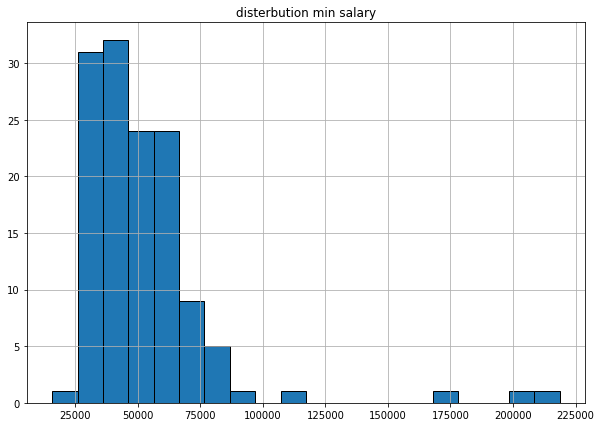

In [35]:
plt.figure(figsize=(10,7))
disterbution_pdf["min(normalized_salary_from)"].hist(bins=20,ec='black')
plt.title('disterbution min salary');
plt.savefig("result/2_distribution_per_job_category_min_salary.png", dpi=300)

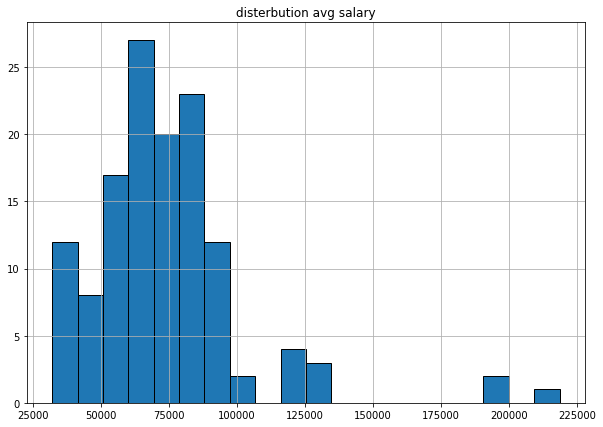

In [36]:
plt.figure(figsize=(10,7))
disterbution_pdf["avg(avg_normalized_salary)"].hist(bins=20,ec='black')
plt.title('disterbution avg salary');
plt.savefig("result/2_distribution_per_job_category_avg_salary.png", dpi=300)

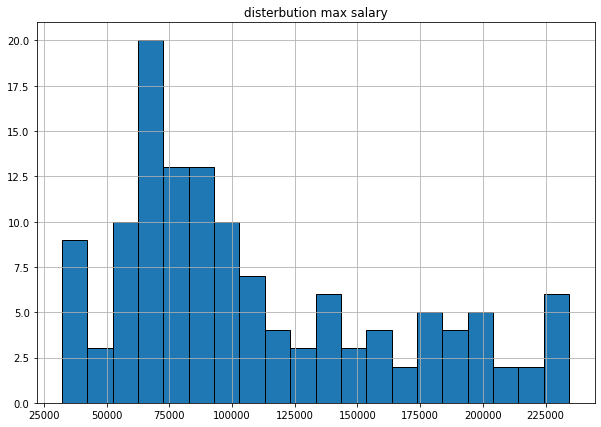

In [37]:
plt.figure(figsize=(10,7))
disterbution_pdf["max(normalized_salary_to)"].hist(bins=20,ec='black')
plt.title('disterbution max salary');
plt.savefig("result/2_distribution_per_job_category_max_salary.png", dpi=300)

# Is there any correlation between the higher degree and the salary?<a id="8"></a> <br>

In [38]:
df=df.withColumn('degree_text',concat(col("job_description"),\
                                      lit(" , "),col("minimum_qual_requirements"),\
                                      lit(" , "),col("preferred_skills"),\
                                      lit(" , "),col("additional_information")))

In [39]:
df.select("degree_text").filter("degree_text like '%Masters%'").count()

59

In [40]:
df = df.withColumn("degree_text", F.regexp_replace("degree_text", "â€™", ""))\
        .withColumn("degree_text", F.regexp_replace("degree_text", "'", ""))\
        .withColumn("degree_text", F.lower("degree_text"))

1.intern, 
2.BA, Bachelor, BS
3.Master, graduate degree, Masters
4.MBA


In [41]:
df.filter("degree_text like '% associates %'").select("degree_text").count()

18

In [42]:
df.filter("degree_text like '% intern %'").select("degree_text").count()

18

In [43]:
df.filter("degree_text like '% ba %'").select("degree_text").count()

2

In [44]:
df.filter("degree_text like '% bachelor %'").select("degree_text").count()

6

In [45]:
df.filter("degree_text like '% masters %'").select("degree_text").count()

656

In [46]:
df.filter("degree_text like '% graduate degree %'").select("degree_text").count()

12

In [47]:
df.filter("degree_text like '% phd %'").select("degree_text").count()

0

In [48]:
# Categorical Encoding
df = df.withColumn("Degree", 
                    when((col("degree_text").contains(" intern ")),1)\
                   .when((col("degree_text").contains(" associates ")),1)\
                   .when((col("degree_text").contains(" ba ")),2)\
                   .when((col("degree_text").contains(" bachelor ")),2)\
                   .when((col("degree_text").contains(" masters ")),3)\
                   .when((col("degree_text").contains(" graduate degree ")),3)\
                   .otherwise(4))

In [49]:
df.select("Degree").distinct().head(5)

[Row(Degree=1), Row(Degree=3), Row(Degree=4), Row(Degree=2)]

In [50]:
deegree_df = df.groupBy("Degree").agg({'avg_normalized_salary':'avg'})

In [51]:
deegree_pdf = deegree_df.toPandas()

In [52]:
deegree_pdf.corr()

,Degree,avg(avg_normalized_salary)
Degree,1.000000,0.770438
avg(avg_normalized_salary),0.770438,1.000000


In [53]:
deegree_pdf.corr().to_csv('result/3_correlation_between_the_higher_degree_and_the_salary.csv')

# Answer: Yes, there is correlation between the higher degree and the salary == 0.770438<a id="9"></a> <br>

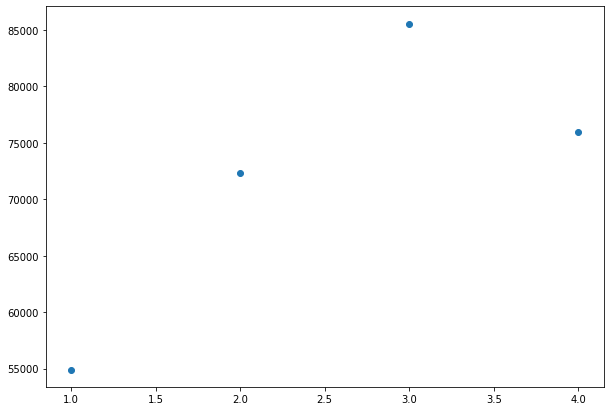

In [54]:
plt.figure(figsize=(10,7))
plt.scatter(x=deegree_pdf['Degree'], y=deegree_pdf['avg(avg_normalized_salary)'])
plt.savefig("result/3_correlation_between_the_higher_degree_and_the_salary.png", dpi=300)

# What's the job posting having the highest salary per agency?<a id="10"></a> <br>

In [55]:
windowDept = Window.partitionBy("agency").orderBy(col("normalized_salary_to").desc())
df = df.withColumn("agency_ranking",row_number().over(windowDept)) 

In [56]:
df.filter(col("agency_ranking") == 1).sort('normalized_salary_to', ascending=False)\
                                        .toPandas().to_csv('result/4_job_with_highest_salary_per_agency.csv')

# What's the job postings average salary per agency for the last 2 years?<a id="11"></a> <br>

In [57]:
df.agg({'process_date':'max', 'posting_updated':'max', 'posting_date':'max', 'post_until':'max'}).head(3)

[Row(max(posting_updated)='2019-12-16', max(process_date)='2019-12-17', max(post_until)='5999-12-31', max(posting_date)='2019-12-17')]

In [58]:
df.agg({'process_date':'min', 'posting_updated':'min', 'posting_date':'min', 'post_until':'min'}).head(3)

[Row(min(posting_updated)='2011-06-24', min(process_date)='2019-12-17', min(post_until)='2019-12-18', min(posting_date)='2011-06-24')]

In [59]:
agency_salary_df = df.where("posting_date > '2017-12-17'").groupBy("agency")\
                                                            .agg({'avg_normalized_salary':'avg'})\
                                                            .sort('avg(avg_normalized_salary)', ascending=False)\
                                                            .toPandas()

In [60]:
agency_salary_df

,agency,avg(avg_normalized_salary)
0,CONFLICTS OF INTEREST BOARD,135000.000000
1,NYC EMPLOYEES RETIREMENT SYS,98336.027778
2,BOARD OF CORRECTION,96222.500000
3,FINANCIAL INFO SVCS AGENCY,96021.129032
4,DEPARTMENT OF SANITATION,92158.948000
5,DEPT OF INFO TECH & TELECOMM,92062.662611
6,NYC HOUSING AUTHORITY,89986.446285
7,DEPT OF DESIGN & CONSTRUCTION,87849.338028
8,MAYORS OFFICE OF CONTRACT SVCS,87357.142857
9,LAW DEPARTMENT,87349.919853


In [61]:
agency_salary_df.to_csv('result/5_average_salary_per_agency_for_the_last_2_years.csv')

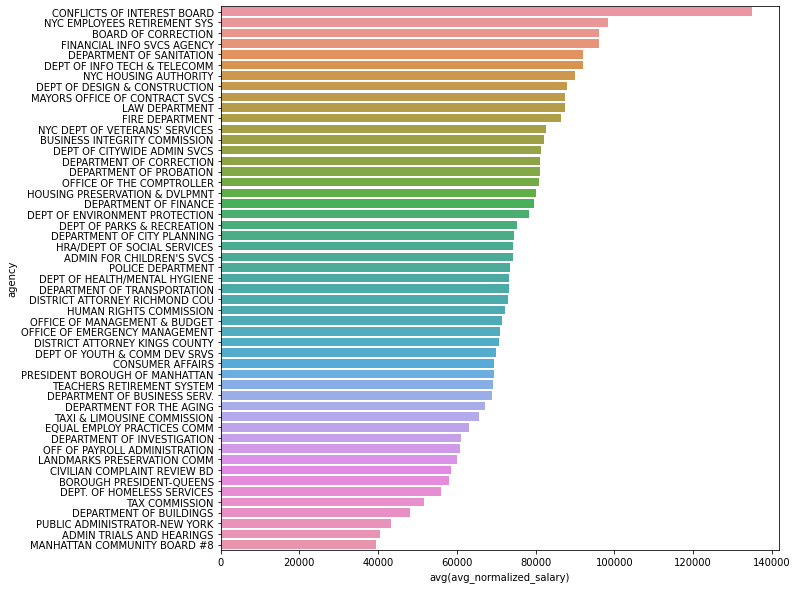

In [62]:
plt.rcParams['figure.figsize']=(10,10)
sns.barplot(x='avg(avg_normalized_salary)', y='agency',data=agency_salary_df)
plt.savefig("result/5_average_salary_per_agency_for_the_last_2_years.png", dpi=300)

# What are the highest paid skills in the US market?<a id="12"></a> <br>


### first of all we should find median fo normalized_salary_to per job_category

In [63]:
median_salary_df = df.groupBy('job_category').agg(F.collect_list('normalized_salary_to').alias('salary_array'))

In [64]:
median_salary_df.head(10)

[Row(job_category=None, salary_array=[65485.0, 162014.0]),
 Row(job_category='Administration & Human Resources', salary_array=[60000.0, 125000.0, 125000.0, 68181.0, 94392.0, 34161.4, 168433.0, 168433.0, 64662.0, 32781.0, 32781.0, 37320.4, 57590.0, 62684.0, 71794.0, 41392.0, 55228.0, 98100.0, 36218.0, 33764.0, 134433.0, 36400.0, 40962.0, 73147.0, 74479.0, 57093.0, 36309.0, 81535.0, 81535.0, 161497.0, 57093.0, 55228.0, 38439.65, 137410.0, 80000.0, 60000.0, 110000.0, 54913.0, 55430.0, 50763.0, 35984.0, 40629.0, 57236.0, 33906.0, 53993.0, 100000.0, 81535.0, 53993.0, 57590.0, 41848.0, 64662.0, 36218.0, 35098.0, 54879.0, 71794.0, 35984.0, 36218.0, 34161.4, 61000.0, 60990.0, 50000.0, 33906.0, 83981.0, 77000.0, 97873.0, 55228.0, 98100.0, 75000.0, 136023.0, 95022.0, 150371.0, 71794.0, 36400.0, 40962.0, 61000.0, 71794.0, 68181.0, 36309.0, 37320.4, 35984.0, 35984.0, 137410.0, 62684.0, 36218.0, 63794.0, 150371.0, 178873.0, 85000.0, 110000.0, 54879.0, 50763.0, 60000.0, 36218.0, 57236.0, 57236.0, 73

In [65]:
median_salary_df = median_salary_df.withColumn('salary_array', F.array_sort(F.expr('filter(salary_array, x -> x is not null)')))\
                .withColumn('size', F.size('salary_array'))\
                .withColumn('median_col', F.when(F.col('size') % 2 == 0,
                                            (F.expr('salary_array[int(size/2)]') + F.expr('salary_array[int(size/2)-1]'))/2
                                            ).otherwise(F.expr('salary_array[int(size/2)]'))
                       )

In [66]:
median_salary_df.head(20)

[Row(job_category=None, salary_array=[65485.0, 162014.0], size=2, median_col=113749.5),
 Row(job_category='Administration & Human Resources', salary_array=[32781.0, 32781.0, 33764.0, 33764.0, 33906.0, 33906.0, 34161.4, 34161.4, 35098.0, 35984.0, 35984.0, 35984.0, 35984.0, 36218.0, 36218.0, 36218.0, 36218.0, 36218.0, 36218.0, 36309.0, 36309.0, 36400.0, 36400.0, 37320.4, 37320.4, 38439.65, 38439.65, 40629.0, 40629.0, 40962.0, 40962.0, 41392.0, 41392.0, 41848.0, 48183.0, 50000.0, 50763.0, 50763.0, 53993.0, 53993.0, 54879.0, 54879.0, 54913.0, 54913.0, 54913.0, 55228.0, 55228.0, 55228.0, 55228.0, 55228.0, 55228.0, 55228.0, 55430.0, 56798.0, 56798.0, 57093.0, 57093.0, 57093.0, 57093.0, 57236.0, 57236.0, 57236.0, 57590.0, 57590.0, 58478.0, 60000.0, 60000.0, 60000.0, 60000.0, 60000.0, 60990.0, 61000.0, 61000.0, 62684.0, 62684.0, 63794.0, 63794.0, 64662.0, 64662.0, 64662.0, 64662.0, 65000.0, 66195.0, 68181.0, 68181.0, 68267.0, 68267.0, 71794.0, 71794.0, 71794.0, 71794.0, 73147.0, 73147.0, 74479

In [67]:
median_salary_df.groupBy("job_category").agg({'median_col':'max'}).sort('max(median_col)', ascending=False).head(1)

[Row(job_category='Administration & Human Resources Finance, Accounting, & Procurement Building Operations & Maintenance', max(median_col)=218587.0)]

In [68]:
df.filter("job_category = 'Administration & Human Resources Finance, Accounting, & Procurement Building Operations & Maintenance'")\
                    .select("preferred_skills","job_category","normalized_salary_to").distinct().count()

1

In [69]:
df.filter("job_category = 'Administration & Human Resources Finance, Accounting, & Procurement Building Operations & Maintenance'")\
                    .select("preferred_skills","job_category","normalized_salary_to").distinct().head(2)

[Row(preferred_skills='The Deputy Commissioner position requires excellent leadership, communication and client service skills as well as a passion for driving innovation, continuous improvement and efficiency, and implementing workforce strategies to recruit, develop and retain the most qualified and diverse talent in a customer service environment. The selected candidate will be expected to work closely with Agency and oversight counterparts and must have excellent management skills focused on staff alignment with the Bureauâ€™s vision, goals and career development. In addition, he/she must be an effective team player, capable of sustaining a culture of excellence in the delivery of customer service to internal partners and possess the ability to establish and maintain effective external partnerships and collaboration.   Specifically, the following skills and abilities are required to be successful in this role:    â€¢\t7-10 years relevant work experience leading customer focused fun

- excellent leadership, communication and client service skills
- passion for driving innovation, continuous improvement and efficiency,
- implementing workforce strategies to recruit, 
- develop and retain the most qualified and diverse talent in a customer service environment,
- excellent management skills focused on staff alignment with the Bureaus vision, goals and career development,
- effective team player, 
- capable of sustaining a culture of excellence in the delivery of customer service to internal partners and possess the ability to establish and maintain effective external partnerships and collaboration,
- 7-10 years relevant work experience leading customer focused functions of which at least 3 years must have been in a senior leadership position,
- BA/BS degree,
- MBA/advanced degree preferred,
- Strong analytical skills,
- **Outstanding written and oral communication skills ,
- **Comfort in managing concurrent projects in a fast-paced, results-driven environment with equal enthusiasm for high-level strategic planning and tactical daily execution,
- **tIn-depth knowledge of Federal, City and State governmental rules and regulations related to the position,
- **NYC experience is a plus,
- **Proficiency in Microsoft Office Suite,